In [12]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm
from dateutil import tz
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags, date, time, date_time  
                from tweets where (date_time >= NOW() - '12 hour'::INTERVAL) and hashtags is not null and hashtags != 'None';'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)

In [5]:
len(df)

5430

In [6]:
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
#df['dayofweek'] = df.created_datetime.apply(lambda x: x.dayofweek)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)

In [25]:
import pickle
!pip install redis
import redis
redis_ip = '34.211.59.66'

r = redis.StrictRedis(redis_ip)
r.keys()

[b'tweet_tfidf_fit_transform',
 b'tweet_SVD_fit',
 b'temp_hash_count_12hr',
 b'hashtags_tfidf_fit_transform',
 b'hashtags_countvec_fit_temp',
 b'tweet_tfidf_fit',
 b'hashtags_countvec_fit',
 b'hashtag_tfidf',
 b'hashtags_countvec_fit_transform']

In [8]:
hastages_series = df['hashtags']

In [9]:
len(hastages_series)

5430

In [32]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec = count_vectorizer.fit(hastages_series)
#hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
#r.set('hashtags_countvec_fit_temp', hashtags_countvec)

In [214]:
#hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit_temp'))

In [20]:
cv_svd_pipe = Pipeline([
    ('tfidf',CountVectorizer(min_df = 1, stop_words='english')),
    ('svd',TruncatedSVD(n_components=25))
])
cv = cv_svd_pipe.steps[0][1]
svd = cv_svd_pipe.steps[1][1]

In [23]:
cv.vocabulary

In [59]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .5)
time_gap = timedelta(hours = 0.1)
windows = int(round(time_delta/time_gap,0))
print('start time: ', min(df['created_datetime']),'\n',\
      'end time:  ', max(df['created_datetime']),'\n',\
      'total hours: ',time_window,'\n',\
      'time lag: ', time_lag,'\n',\
      'time gap: ', time_gap,'\n',\
      'time windows: ', windows)

start time:  2017-06-09 12:41:48 
 end time:   2017-06-09 19:40:20 
 total hours:  6 
 time lag:  0:30:00 
 time gap:  0:06:00 
 time windows:  70


In [60]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .25)
time_gap = timedelta(hours = .1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap
    arr = np.array(arr)  
    
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spikes = []
    [spikes.append(i) for i in tr if (i-1) not in tr]
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency')
    plt.plot(grad, label='Frequency Slope')
    
    for i,j in enumerate(spikes):
        spiketime = (min(df['created_datetime']) + time_gap * j) 
        spiketime = spiketime.replace(tzinfo=from_zone)
        spiketime_et = spiketime.astimezone(to_zone)
        spiketime_et = spiketime_et.strftime(time_format)
        
        plt.axvline(j, color = 'r',linestyle='dashed', label = 'Trending: {}'.format(spiketime_et))
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12)   
    return  

In [45]:
hashtags_countvec.vocabulary_.keys()

dict_keys(['coward', 'retiredathlete', 'mockingbirdlove', 'steviewonder', 'catsoftwitter', 'bye', 'americanpolitics', 'aqauriumday', 'athletics', 'professional', 'trendinghouse', 'theorilayers', 'poppers', 'bbc', 'iftar', 'bbjackk', 'share', 'cyber', 'dronetv', 'artseamdr', 'ncaatf', 'pesto', 'lockhimup', 'brewersrow', 'eightytwola', 'musicrow', 'slixagirl', 'mytwitteranniversary', 'season5', 'izakaya', 'akaimpactday', 'drawstring', 'year', 'rebelonbet', 'gop', 'unconditional', 'bus', 'firstphoto', 'carrollton', 'jl99', 'sky', 'buddies', 'tytlive', 'hopelessfountainkingdom', 'buccadibeppo', 'gospelmusic', 'westhollyoodliving', 'standwithsongwriters', 'iseeyou', 'drainingtheswamp', 'tallandbeautiful', 'highschool', 'iriemitch', 'andimack', 'repost', 'free', 'followfriday', 'goprepublicans', 'daddy', 'reseda', '3dprint', 'moonlovers', 'thecareconcert', 'echoparkfarmersmarket', 'levelstothisish', 'bathroomselfie', 'happyanniversary', 'indiefilm', 'sunrise', 'breaks', 'unsecuredloans', 'ab

In [43]:
for i in hashtags_countvec.vocabulary_.items():
    print(i)

('coward', 1104)
('retiredathlete', 4041)
('mockingbirdlove', 3223)
('steviewonder', 4529)
('catsoftwitter', 843)
('bye', 740)
('americanpolitics', 226)
('aqauriumday', 271)
('athletics', 319)
('professional', 3850)
('trendinghouse', 4953)
('theorilayers', 4820)
('poppers', 3775)
('bbc', 428)
('iftar', 2414)
('bbjackk', 429)
('share', 4317)
('cyber', 1166)
('dronetv', 1429)
('artseamdr', 302)
('ncaatf', 3386)
('pesto', 3680)
('lockhimup', 2942)
('brewersrow', 669)
('eightytwola', 1506)
('musicrow', 3318)
('slixagirl', 4399)
('mytwitteranniversary', 3352)
('season5', 4266)
('izakaya', 2569)
('akaimpactday', 174)
('drawstring', 1408)
('year', 5399)
('rebelonbet', 3981)
('gop', 2094)
('unconditional', 5067)
('bus', 724)
('firstphoto', 1720)
('carrollton', 824)
('jl99', 2609)
('sky', 4387)
('buddies', 703)
('tytlive', 5048)
('hopelessfountainkingdom', 2351)
('buccadibeppo', 700)
('gospelmusic', 2101)
('westhollyoodliving', 5263)
('standwithsongwriters', 4503)
('iseeyou', 2537)
('drainingth

('thenewmart', 4817)
('makeitsoon', 3043)
('carrevolt', 823)
('man', 3062)
('nationalbestfriends', 3366)
('harmonizers', 2222)
('becomeafan', 466)
('allvinyl', 197)
('retail', 4040)
('raiders', 3930)
('mlp', 3214)
('majorthrowback', 3039)
('kindness', 2700)
('entrylevel', 1552)
('humptydumpty', 2385)
('galgaadot', 1930)
('allin', 192)
('futurelambofunds', 1915)
('orderandchaosshow', 3588)
('playwithhorses', 3742)
('donut', 1385)
('sprechensiedouche', 4488)
('islamistheproblem', 2540)
('angels', 248)
('streetfood', 4550)
('flu', 1759)
('demetriusshippjr', 1254)
('pulsenightclub', 3887)
('health', 2253)
('freespeech', 1834)
('phootgrpahy', 3695)
('professorlife', 3852)
('secondwivesclub', 4268)
('fml', 1772)
('teachinggoals', 4713)
('sonoralove', 4447)
('mlganaheim', 3212)
('kindergarten', 2697)
('jobs', 2612)
('whatsyourjersey', 5281)
('dayoff', 1215)
('land', 2785)
('partisanpolitics', 3636)
('lifestyleshoot', 2889)
('instafreebie', 2487)
('moffettfield', 3234)
('walnut', 5198)
('enano

('traitor', 4924)
('foreigncar', 1796)
('travelskills', 4945)
('oitnb5', 3554)
('dreiser', 1420)
('waters', 5212)
('buttonupbabe', 735)
('thatvoice', 4769)
('giftsizesavailable', 2008)
('imtheman', 2446)
('dislikes', 1322)
('wimps', 5311)
('lafd', 2760)
('pharmaceutical', 3686)
('richardson', 4057)
('gigs', 2011)
('technology', 4735)
('model', 3225)
('blacklove', 571)
('southsanfrancisco', 4466)
('hippie_of_love', 2310)
('ipassedstats', 2517)
('fiesta', 1689)
('graduationweek', 2120)
('mdasf', 3114)
('joemendez', 2615)
('joshuatree', 2625)
('directaction', 1311)
('sunrise_and_sunsets', 4619)
('bicyclecoop', 533)
('thisorthat', 4852)
('durant', 1448)
('ocdcartanddesign', 3539)
('koriegenius', 2724)
('blacklivesmatter', 570)
('time', 4879)
('phd', 3687)
('fatburger', 1651)
('swordsmen', 4662)
('presser', 3825)
('pch', 3654)
('filmmaking', 1697)
('nela', 3396)
('partisanwar', 3637)
('chestday', 895)
('horror', 2356)
('equalitymarch', 1560)
('ianmcshane', 2399)
('trumpsasucker', 4998)
('fa

In [33]:
hashtag_name = hashtags_countvec.get_feature_names()
hashtag_name

['081',
 '10',
 '100mostbeautifulfaces2017',
 '13reasonswhy',
 '15325',
 '1800bailout',
 '19',
 '1989',
 '1989streamingparty',
 '1999',
 '1hr',
 '1star',
 '1stcar',
 '1u',
 '2007',
 '2017ada',
 '2017btsfesta',
 '2017grads',
 '2017lineup',
 '2017rapplaylist',
 '2017staymakingboratjokes',
 '2018midterms',
 '2020',
 '21',
 '213',
 '21massacre',
 '22',
 '23',
 '24',
 '245',
 '24hourfitness',
 '24hours',
 '25',
 '2514pearlstreet',
 '25thamendment',
 '28',
 '2k17',
 '2ndgrade',
 '2pac',
 '2u',
 '30in30',
 '31philliplim',
 '360video',
 '39',
 '3carat',
 '3dprint',
 '3dprinting',
 '3ndz4ev',
 '3parksin3days',
 '3rdaxisradio',
 '401k',
 '420',
 '45',
 '49ers',
 '4dr',
 '4everfriday',
 '4granddaughter',
 '4sup',
 '5000jersey',
 '500k',
 '50cent',
 '562',
 '5900wilsire',
 '5npf259',
 '5o5o',
 '5thgrade',
 '60sarchitecture',
 '65daysofkicks',
 '680',
 '6917heyheyhey',
 '6daystill1',
 '6lack',
 '6packsummercamp',
 '70',
 '714ever',
 '722',
 '76ers',
 '7forallmankind',
 '7stringguitar',
 '805family'

In [ ]:
hashtag_trend(hashtag)

In [50]:
hashtag_name = hashtags_countvec.get_feature_names()
tag = []
start_time = min(df['created_datetime'])
for window in tqdm(range(windows)):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        for hashtag in hashtag_name:
            tag.append([window,hashtag,sum(subset.str.contains(hashtag))])

100%|██████████| 7/7 [01:01<00:00,  8.80s/it]


In [202]:
temp_hash_count_12hr = pickle.dumps(tag)
r.set('temp_hash_count_12hr', temp_hash_count_12hr)

True

In [203]:
temp_hash_count_12hr = pickle.loads(r.get('temp_hash_count_12hr'))

In [204]:
hash_count_12hr_df = pd.DataFrame(temp_hash_count_12hr, columns = ['window','hashtag','count'])

In [206]:
len(hash_count_12hr_df)

318384

In [207]:
len(hash_count_12hr_df.groupby(['hashtag'])['count'])

13266

In [216]:
hash_count_12hr_df.groupby(['hashtag'])['count'].sum()

hashtag
009                               0
06                               48
08                               24
0nceuponatime                     0
10                              312
100                             144
100dayproject                    24
100daysofjustdeandre              0
100kpyramid                       0
100million                        0
100szn                            0
101                               0
1020                              0
106                               0
107                              96
108                               0
109                               0
10news                            0
10thplanetfightteam               0
10x                               0
10xgrowthcon                      0
10yearsold                        0
11                               24
110                               0
110freeway                        0
11thhour                          0
12                                0
1200bucks           

In [ ]:
len(df[df['hashtags'].str.contains('100')])

In [224]:
hashtag_name = hashtags_countvec.get_feature_names()
hashtag = hashtag.lower()
trending =[]   
for hashtag in tqdm(hashtag_name):
    arr = []
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)    
    arr = np.array(arr)  
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.003).reshape(1,-1)[0]
    spikes = []
    [spikes.append(i) for i in tr if (i-1) not in tr]
    if spikes != []:
        trending.append[[hashtag, spikes]]
    
    
        
        

100%|██████████| 13266/13266 [11:59<00:00, 18.59it/s]


In [ ]:
>> data.groupby(func, axis=0).mean()
>>> data.groupby(['col1', 'col2'])['col3'].mean()

In [91]:
subset, arr, grad, spikes = hashtag_trend_t('battery')

In [132]:
trend = np.array([trending[i][1] for i in range(len(trending))])
trending[np.argmax(trend)][1]

0.0052796769817823434

In [88]:
grad

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.60475283e-05,   1.11881853e-04,
        -1.56627343e-07,  -1.11881853e-04,   8.15418678e-06,
         1.06860440e-04,   8.56307050e-05])

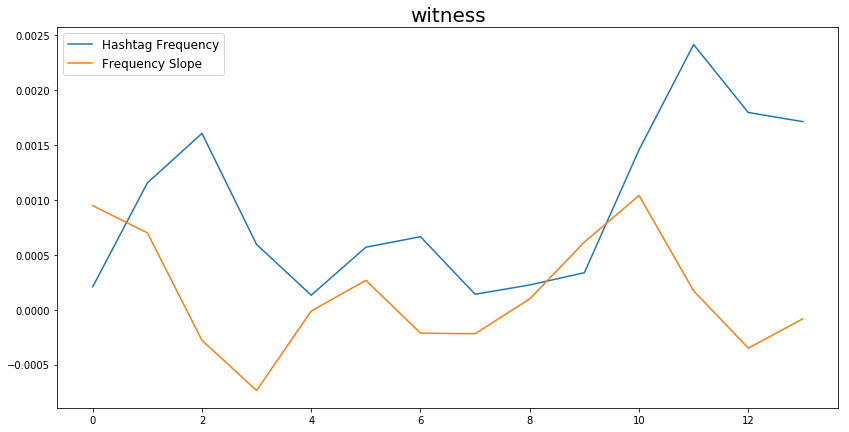

In [133]:
hashtag_trend('WITNESS')

In [88]:
np.argmax(nbafinals_grad).reshape(1,-1)[0]

array([124])

In [ ]:
nbafinals_grad[61]

In [80]:
nbafinals_grad[23]

0.046130180327304676

In [81]:
(np.argwhere(nbafinals_grad>.01).reshape(1,-1)[0])

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([23, 24, 94, 95, 96, 97])

In [82]:
spikes = []
tr = np.argwhere(nbafinals_grad>.01).reshape(1,-1)[0]
[spikes.append(i) for i in tr if (i-1) not in tr]
        
spikes        

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


[23, 94]

In [83]:
np.argmax(nbafinals)

125

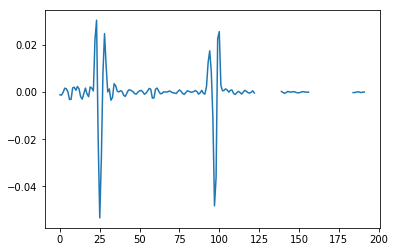

In [84]:
plt.plot(np.gradient(nbafinals_grad))

In [65]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .25)
time_gap = timedelta(hours = .1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap
    arr = np.array(arr)  
    
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spikes = []
    [spikes.append(i) for i in tr if (i-1) not in tr]
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency')
    plt.plot(grad, label='Frequency Slope')
    
    for i,j in enumerate(spikes):
        spiketime = (min(df['created_datetime']) + time_gap * j) 
        spiketime = spiketime.replace(tzinfo=from_zone)
        spiketime_et = spiketime.astimezone(to_zone)
        spiketime_et = spiketime_et.strftime(time_format)
        
        plt.axvline(j, color = 'r',linestyle='dashed', label = 'Trending: {}'.format(spiketime_et))
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12)   
    return  arr, grad

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


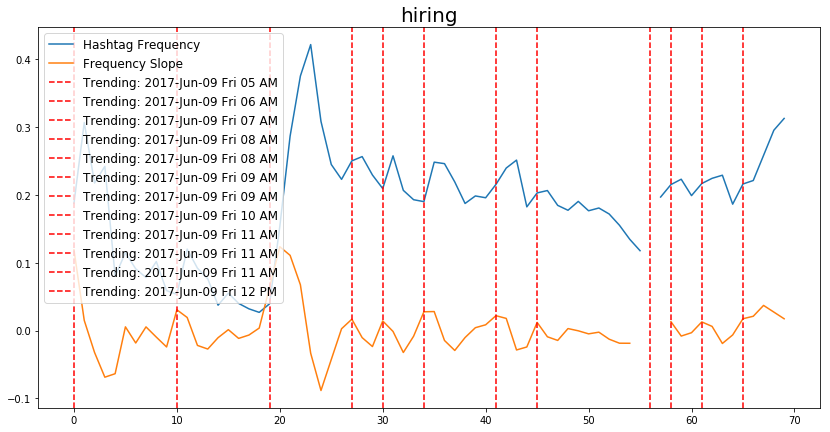

In [75]:
arr, grad = hashtag_trend('hiring')

In [67]:
spikes = []
tr = np.argwhere(grad>.01).reshape(1,-1)[0]
[spikes.append(i) for i in tr if (i-1) not in tr]
        
spikes 

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


[]

In [70]:
np.argmax(grad).reshape(1,-1)[0]

array([55])

In [71]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

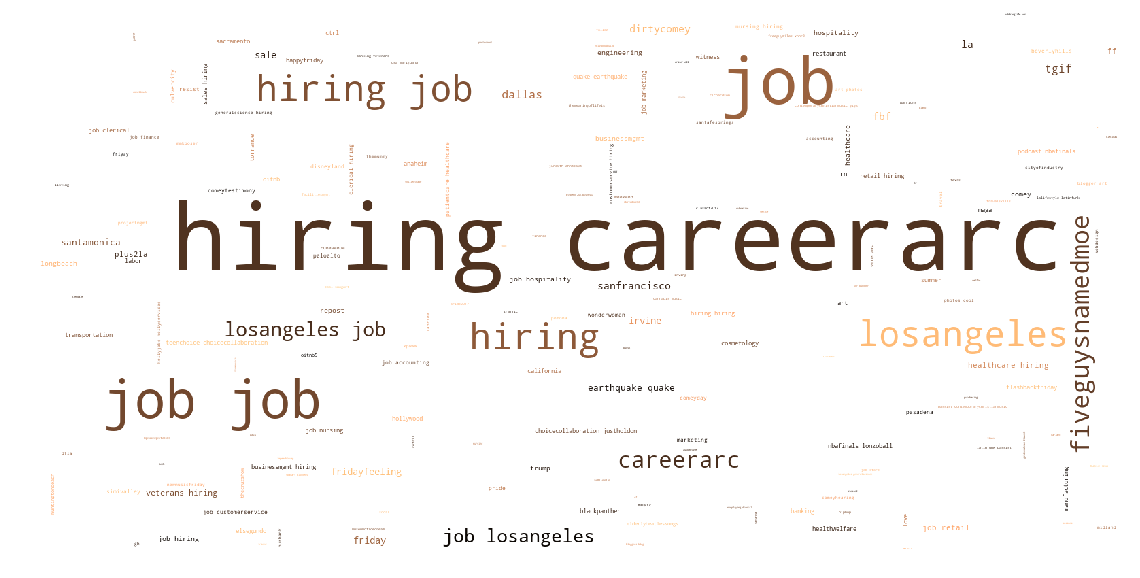

In [74]:
stopwords = set(STOPWORDS)
neutral_wc = WordCloud(width=1600, height=800, background_color='white', relative_scaling=1, stopwords=stopwords, colormap='copper').generate(' '.join(i for i in df['hashtags']))

plt.figure(figsize=(20,10))
plt.imshow(neutral_wc)
plt.axis("off")
plt.show()